# **Analysis of Perturbations in Single-Cell RNA-Seq Data**

First, we create `PertData` object to load and handle perturbation data.
We specify that we want to load the `norman` dataset.

In [ ]:
import pertdata as pt

norman = pt.PertData.from_repo(name="norman", save_dir="..\\..\\projects\\scrnaseq_project\\data")

Dataset directory already exists: ..\..\projects\scrnaseq_project\data\norman
Loading dataset: norman


: 

# Analysis and Preparation of Single-Cell RNA-Seq Data

The actual perturbation data is stored in an [`AnnData`](https://anndata.readthedocs.io/en/latest/) object.
`AnnData` is specifically designed for matrix-like data.
By this we mean that we have $n$ observations, each of which can be represented as $d$-dimensional vectors, where each dimension corresponds to a variable or feature.
Both the rows and columns of this $n \times d$-matrix are special in the sense that they are indexed.
For instance, in scRNA-seq data, each row corresponds to a cell with a barcode, and each column corresponds to a gene with a gene identifier.

Here we show how to access the **gene expression matrix**, the **perturbations labels**, the **control labels**, and the **gene names**.

In [2]:
print(norman)
print(norman.adata)

X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]

print(f"X.shape={X.shape}")  # type: ignore
print(f"y_pert.shape={y_pert.shape}")
print(f"y_ctrl.shape={y_ctrl.shape}")
print(f"gene_names.shape={gene_names.shape}")

PertData object
    name: norman
    path: ..\..\projects\scrnaseq_project\data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
X.shape=(91205, 5045)
y_pert.shape=(91205,)
y_ctrl.shape=(91205,)
gene_names.shape=(5045,)


In general, in a perturbation dataset, we find $k$ cell lines.
Usually, one cell line remains unperturbed, and the others are cultivated separately (with different perturbations, i.e., gene knockouts).
The mRNA of usually a few thousand cells of each cell line is sequenced (using a single-cell RNA sequencing protocol), generating the $n$ $d$-dimensional gene expression profiles.
In particular, perturbation labels are available (i.e., we know which genes were knocked out in each cell line).

Before we can take a closer look at our data, we need to fix the perturbation labels, because they might be expressed ambiguously (e.g., single-gene perturbations can be expressed as `ctrl+<gene1>` or `<gene1>+ctrl`, falsely leading to two distinct labels for the perturbation of `<gene1>`).

The `PertData` object already contains the fixed perturbation labels, which were computed during initialization.

In [3]:
print(f"Unique perturbations (unfixed): {len(set(norman.adata.obs['condition']))}")
print(f"Unique perturbations (fixed): {len(set(norman.adata.obs['condition_fixed']))}")

Unique perturbations (unfixed): 284
Unique perturbations (fixed): 237


Furthermore, we will work with single-gene perturbations only.
Hence, we have to filter out double-gene perturbations.

##### ❓ Filtering out double-gene perturbations

Complete the following code to filter out double-gene perturbations from the `AnnData` object.
Double-gene perturbations can be identified by a `+` in the fixed perturbation labels.

In [4]:
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()  # type: ignore

Let's take a closer look at the new data:

In [5]:
print(adata_single)
print(f"Unique perturbations: {len(set(adata_single.obs['condition_fixed']))}")
print("Number of samples per condition:")
print(adata_single.obs["condition_fixed"].value_counts())

AnnData object with n_obs × n_vars = 55760 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
Unique perturbations: 106
Number of samples per condition:
condition_fixed
ctrl      7353
KLF1      1641
BAK1      1171
CEBPE     1039
ETS2      1031
          ... 
NIT1       165
CDKN1C     165
ZBTB10     145
HES7       122
PLK4        97
Name: count, Length: 106, dtype: int64


Because gene expression data is very sparse, i.e., the expression is often not measured successfully or correctly, we will limit our experiment to the 128 genes with the highest variances.

##### ❓ Selecting high-variance genes

Complete the following code.
Make a new `AnnData` object that only contains the top $d$ genes with the highest variances.

In [ ]:
# Number of top genes to select.
d = 128

# Compute the gene variances.
gene_variances = adata_single.X.toarray().var(axis=0)  # type: ignore

# Sort the gene variances in descending order and get the indexes of the top d genes.
sorted_indexes = gene_variances.argsort()[::-1]

# Get the indexes of the top d genes.
top_gene_indexes = sorted_indexes[:d]

# Get the gene names of the top d genes.
top_genes = adata_single.var["gene_name"].iloc[top_gene_indexes]

# Get the variances of the top d genes.
top_variances = gene_variances[top_gene_indexes]

# Print the top d genes with the highest variances.
print(f"Top {d} genes with highest variances:")
for gene, variance in zip(top_genes, top_variances):
    print(f"{gene:15}: {variance:.2f}")

# Create a new AnnData object with only the top d genes.
adata_single_top_genes = adata_single[:, top_gene_indexes].copy()

Using an autoencoder trained on RNA-Seq data can offer several significant advantages, especially when dealing with the complexities inherent to gene expression datasets.

Here, we will highlight two use cases.

1. High Dimensionality of RNA-Seq Data
    - Challenge: RNA-Seq datasets often comprise expression levels for thousands of genes (features), which can lead to the "curse of dimensionality." High-dimensional data can make models like Multi-Layer Perceptrons (MLPs) computationally intensive and prone to overfitting.
    - Solution: Autoencoders can learn a compressed, lower-dimensional representation (latent space) of the data by encoding the input features into a smaller set of latent variables. This reduced representation retains the most critical information, making it easier and more efficient for downstream models (like an MLP) to process the data.

2. Capturing Complex Patterns
    - Challenge: Gene expression data may contain intricate, nonlinear relationships that are not easily captured by traditional linear dimensionality reduction techniques like PCA.
    - Solution: Autoencoders, especially deep or variational ones, can capture complex, nonlinear relationships within the data. The learned latent representations can encapsulate meaningful biological patterns and interactions among genes, providing richer features for classification tasks.

Further reading:

Carlos Ruiz-Arenas, Irene Marín-Goñi, Liewei Wang, Idoia Ochoa, Luis A Pérez-Jurado, Mikel Hernaez, NetActivity enhances transcriptional signals by combining gene expression into robust gene set activity scores through interpretable autoencoders, Nucleic Acids Research, Volume 52, Issue 9, 22 May 2024, Page e44, https://doi.org/10.1093/nar/gkae197

Abstract:

"Grouping gene expression into gene set activity scores (GSAS) provides better biological insights than studying individual genes. However, existing gene set projection methods cannot return representative, robust, and interpretable GSAS. We developed NetActivity, a machine learning framework that generates GSAS based on a sparsely-connected autoencoder, where each neuron in the inner layer represents a gene set. [...]"

# Training an Autoencoder on Single-Cell RNA-Seq Data

First, we prepare our data.

Note that we shuffle the data in the `train_loader` but not in the `test_loader`.

Shuffling the training data is a common practice to ensure that the model does not learn the order of the data.
It helps in breaking correlations by preventing the model from learning any unintended patterns or correlations that might exist in the order of the training data.

Shuffling is typically not used for the testing data because non-shuffled data ensures that the evaluation is consistent and reproducible.
The model is tested on the same data in the same order each time, which is important for comparing performance across different runs.

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the gene expression matrix to a PyTorch tensor.
X = torch.tensor(data=adata_single_top_genes.X.toarray(), dtype=torch.float32)  # type: ignore

# Create a PyTorch dataset.
dataset = TensorDataset(X, X)

# Create train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

# Number of workers.
num_workers = 3

# Create train and test data loaders.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
)

##### ❓ Creating an autoencoder

Create an autoencoder for the RNA-Seq data using the `Autoencoder` class from `models.py`.

In [2]:
import pytorch_lightning as pl
from models import Autoencoder

# Get the number of features.
n_features = X.shape[1]
print(f"n_features={n_features}")

# Get the number of samples.
n_samples = X.shape[0]  # = len(train_dataset) + len(test_dataset) = len(dataset)
print(f"n_samples={n_samples}")

# Create the autoencoder
autoencoder = Autoencoder(in_features=n_features)

ModuleNotFoundError: No module named 'pytorch_lightning'

Next, we train the autoencoder:

In [11]:
from pytorch_lightning.loggers import CSVLogger

# Initialize the CSV logger.
logger = CSVLogger(save_dir="lightning_logs", name="ae_experiment")

# Train the autoencoder.
trainer = pl.Trainer(max_epochs=4, logger=logger)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 12.4 K | train
1 | decoder | Decoder | 12.5 K | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
24.9 K    Trainable params
0         Non-trainable params
24.9 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 697/697 [00:15<00:00, 45.88it/s, v_num=0, batch_idx=696.0, train_loss=0.173]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 697/697 [00:15<00:00, 45.80it/s, v_num=0, batch_idx=696.0, train_loss=0.173]


Then, we test the model:

In [12]:
# Test the autoencoder.
trainer.test(model=autoencoder, dataloaders=test_loader)

Testing DataLoader 0: 100%|██████████| 175/175 [00:02<00:00, 64.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.19174818694591522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.19174818694591522}]

##### ❓ Plotting the training loss

Complete the following code to plot the training loss over the steps.

logfile=lightning_logs\ae_experiment\version_0\metrics.csv


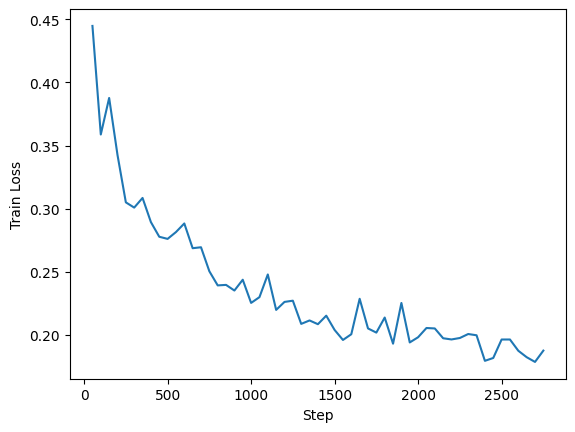

In [13]:
import os

import matplotlib.pyplot as plt
import pandas as pd


def plot_train_loss(logfile: str) -> None:
    """Plot the training loss from a PyTorch Lightning log file."""
    print(f"logfile={logfile}")
    log = pd.read_csv(filepath_or_buffer=logfile)
    plt.plot(log["step"], log["train_loss"])
    plt.xlabel("Step")
    plt.ylabel("Train Loss")
    plt.show()


# Construct the path to the most recent version directory.
most_recent_metrics_file = os.path.join(
    logger.save_dir, logger.name, f"version_{logger.version}", "metrics.csv"
)

# Plot the training loss.
plot_train_loss(logfile=most_recent_metrics_file)